# Cubo de identificación de inscritos

## Este script utiliza XGBoost para identificar posibles inscritos a partir de características derivadas
## de alumnos ya registrados. Además, implementa GridSearchCV para optimizar los hiperparámetros del modelo.

# Importación de bibliotecas y configuración

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, RocCurveDisplay
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
from sklearn.calibration import calibration_curve, CalibrationDisplay

# Ignorar advertencias
warnings.simplefilter("ignore")

# Configuración de pandas
pd.set_option('display.max_rows', 100)
pd.set_option("display.max_columns", 500)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

# 1. Carga y exploración de los datos

In [2]:
print("Cargando datos...")
df = pd.read_excel("Cubo_2.xlsb")
df.columns = df.columns.str.replace(' ', '_')  # Reemplazo de espacios en nombres de columnas

# Mostrar información inicial de los datos
print("Primer vistazo a los datos:")
print(df.columns)
df.info()
df.describe().T


Cargando datos...
Primer vistazo a los datos:
Index(['Record_ID', 'Nombre', 'Apellidos', 'APELLIDO_MATERNO',
       'NIVEL_DE_INTERES', 'ESTATUS', 'ESCUELA', 'EMPRESA', 'ORIGEN',
       'PROGRAMA', 'TURNO', 'PERIODO', 'MATRICULA', 'FECHA_DE_PAGO_1',
       'CANTIDAD_PAGO_1', 'METODO_DE_PAGO_1', 'FECHA_DE_PAGO_2',
       'CANTIDAD_PAGO_2', 'METODO_DE_PAGO_2', 'DESCUENTO_INSCRIPCIÓN', 'BECA',
       'TIPO_DE_BECA', 'RECOMENDADO_POR:',
       'DESCUENTO_DE_EXAMEN_OTRA_INSTITUCION', 'TALLA',
       'Creado_por_el_ID_de_usuario', 'OPCION_DE_UNIVERSIDAD_1',
       'OPCION_DE_UNIVERSIDAD_2', 'OPCION_DE_UNIVERSIDAD_3',
       'Propietario_del_contacto', 'Fecha_de_creación', 'Último_contacto',
       'Última_actividad', 'Última_modificación',
       'Fecha_de_la_apertura_más_reciente_de_un_correo_de_ventas',
       'Fecha_del_clic_más_reciente_en_un_correo_de_ventas',
       'Fecha_de_la_respuesta_más_reciente_a_un_correo_de_ventas',
       'Correos_de_marketing_abiertos', 'Correos_de_marketing

,count,mean,std,min,25%,50%,75%,max
Record_ID,7318.00,1621603.24,434972.34,5701.00,1345313.50,1608676.00,1833938.50,3901551.00
MATRICULA,447.00,2035.85,736.19,18.00,1492.50,2378.00,2520.50,2683.00
FECHA_DE_PAGO_1,339.00,45035.02,107.65,44547.00,44943.00,45050.00,45124.50,45194.00
CANTIDAD_PAGO_1,335.00,1254.93,723.05,200.00,1140.00,1140.00,1350.00,9250.00
FECHA_DE_PAGO_2,13.00,44948.77,116.45,44784.00,44890.00,44898.00,45016.00,45148.00
CANTIDAD_PAGO_2,13.00,715.23,371.56,140.00,560.00,770.00,840.00,1675.00
DESCUENTO_INSCRIPCIÓN,259.00,1513.59,365.09,0.00,1500.00,1500.00,1710.00,2370.00
DESCUENTO_DE_EXAMEN_OTRA_INSTITUCION,13.00,800.00,0.00,800.00,800.00,800.00,800.00,800.00
Fecha_de_creación,7318.00,44961.31,109.43,43774.80,44928.53,44980.70,45008.68,45257.73
Último_contacto,7222.00,45138.50,56.78,44543.76,45117.68,45155.40,45170.62,45321.40


# 2. Creación de columnas derivadas de acciones realizadas por los alumnos

In [3]:
print("Creando columnas derivadas...")
df['Apertura_Correo_Ventas'] = np.where(df['Fecha_de_la_apertura_más_reciente_de_un_correo_de_ventas'].notna() & 
                                        (df['Fecha_de_la_apertura_más_reciente_de_un_correo_de_ventas'] > 0), 1, 0)
df['Clic_Correo_Ventas'] = np.where(df['Fecha_del_clic_más_reciente_en_un_correo_de_ventas'].notna() & 
                                    (df['Fecha_del_clic_más_reciente_en_un_correo_de_ventas'] > 0), 1, 0)
df['Respuesta_Correo_Ventas'] = np.where(df['Fecha_de_la_respuesta_más_reciente_a_un_correo_de_ventas'].notna() & 
                                         (df['Fecha_de_la_respuesta_más_reciente_a_un_correo_de_ventas'] > 0), 1, 0)
df['Apertura_Marketing'] = np.where(df['Correos_de_marketing_abiertos'] > 0, 1, 0)
df['Clic_Marketing'] = np.where(df['Correos_de_marketing_con_clic'] > 0, 1, 0)
df['Ultima_Apertura_Marketing'] = np.where(df['Fecha_de_la_última_apertura_de_un_correo_de_marketing'].notna() & 
                                           (df['Fecha_de_la_última_apertura_de_un_correo_de_marketing'] > 0), 1, 0)
df['Ultimo_Clic_Marketing'] = np.where(df['Fecha_del_último_clic_en_un_correo_de_marketing'].notna() & 
                                       (df['Fecha_del_último_clic_en_un_correo_de_marketing'] > 0), 1, 0)
df['Envios_Formularios'] = np.where(df['Número_de_envíos_de_formularios'] > 1, 1, 0)
df['Ultima_Visualizacion'] = np.where(df['Última_visualización'].notna() & (df['Última_visualización'] > 0), 1, 0)

# Crear columna resumen de acciones
df['Acciones_Realizadas'] = df[['Apertura_Correo_Ventas', 'Clic_Correo_Ventas', 'Respuesta_Correo_Ventas', 
                                'Apertura_Marketing', 'Clic_Marketing', 'Ultima_Apertura_Marketing', 
                                'Ultimo_Clic_Marketing', 'Envios_Formularios', 'Ultima_Visualizacion']].sum(axis=1)


Creando columnas derivadas...


# 3. Creación de la columna objetivo (TARGET) y limpieza de dataframe

In [4]:
print("Creando la columna TARGET...")
df['TARGET'] = np.where(df['ESTATUS'].isin(['05 INSCRITO', '06 INSCRITO-DESCARTADO']), 1, 0)

# Filtrar datos para carreras específicas
print("Filtrando datos...")
df = df[df['PROGRAMA'] != 'MBA']
df = df[df['PROGRAMA'] != 'BACHILLERATO GENERAL CON ENFOQUE EN ADMINISTRACIÓN']

# Eliminar columnas irrelevantes
df = df.drop(columns=[
    'Record_ID', 'Nombre', 'Apellidos', 'APELLIDO_MATERNO', 'ESTATUS', 'MATRICULA', 'TURNO', 
    'PERIODO', 'FECHA_DE_PAGO_1', 'CANTIDAD_PAGO_1', 'METODO_DE_PAGO_1', 'FECHA_DE_PAGO_2', 
    'CANTIDAD_PAGO_2', 'METODO_DE_PAGO_2', 'DESCUENTO_INSCRIPCIÓN', 'BECA', 'TIPO_DE_BECA', 
    'RECOMENDADO_POR:', 'DESCUENTO_DE_EXAMEN_OTRA_INSTITUCION', 'TALLA', 
    'Creado_por_el_ID_de_usuario', 'Propietario_del_contacto', 'Último_contacto', 'Última_actividad', 
    'Última_modificación', 'Fecha_de_la_apertura_más_reciente_de_un_correo_de_ventas', 
    'Fecha_del_clic_más_reciente_en_un_correo_de_ventas', 'Fecha_de_la_respuesta_más_reciente_a_un_correo_de_ventas', 
    'Fecha_de_la_última_apertura_de_un_correo_de_marketing', 'Fecha_del_último_clic_en_un_correo_de_marketing', 
    'Última_visualización', 'Número_de_teléfono', 'Número_de_móvil', 'Número_de_teléfono_de_WhatsApp', 
    'Correo', 'Fecha_de_creación', 'Dirección_de_correo_no_válida'
])


Creando la columna TARGET...
Filtrando datos...


# 4. Preprocesamiento de datos

In [5]:
print("Preprocesando datos...")
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.add_categories('unknown').fillna('unknown').str.lower()

for col in df.select_dtypes(include=['int', 'float']).columns:
    df[col] = df[col].fillna(-1)

# Crear variables dummies y separar datos en X e y
df_dummies = pd.get_dummies(df, drop_first=True)
X = df_dummies.drop(columns=['TARGET'])
y = df_dummies['TARGET']

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Preprocesando datos...


# 5. Entrenamiento y evaluación del modelo

Entrenando el modelo...
Accuracy: 0.9547228727556596
Mejores hiperparámetros: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
ROC AUC: 0.9466028124551585


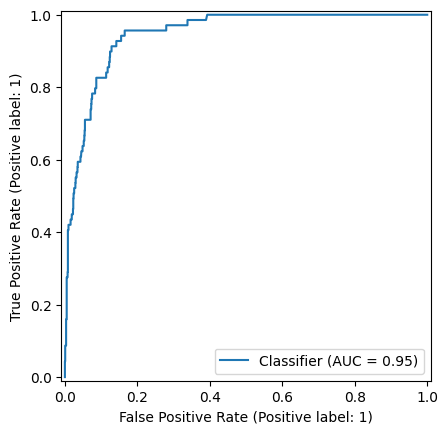

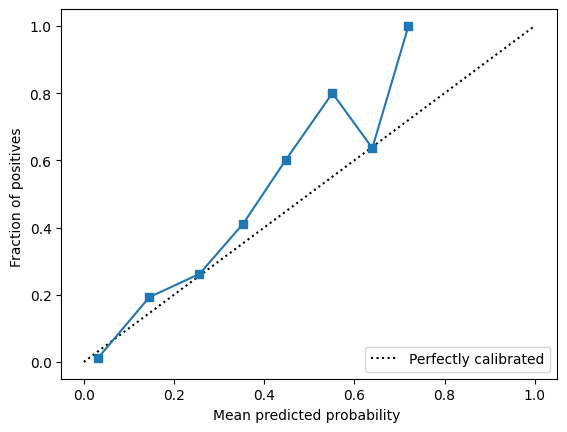

In [6]:
print("Entrenando el modelo...")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

model = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
model.fit(X_train, y_train)

# Métricas de evaluación
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Mejores hiperparámetros: {model.best_params_}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")

# Curva ROC
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.show()

# Calibración del modelo
real_prob, pred_prob = calibration_curve(y_test, y_pred_proba, n_bins=10)
CalibrationDisplay(real_prob, pred_prob, y_pred_proba).plot()
plt.show()
